**Make sure that you've download the dataset and put it in the same folder as this notebook.**

# Load the train and val dataset

In [7]:
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import imageio

In [8]:
def load_data_from_pkl(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

In [9]:
train_set = load_data_from_pkl('train_simple_dict.pkl')
val_set = load_data_from_pkl('val_simple_dict.pkl')

train_left = train_set.keys()
train_right = train_set.values()

val_left = val_set.keys()
val_right = val_set.values() # a list

In [10]:
test_set = load_data_from_pkl('test_simple_dict.pkl')
test_left = test_set.keys()
test_right = test_set.values() # a list
test_left = list(test_left)


### Feat

In [11]:
from scipy.spatial import distance

def find_most_similar_using_l2(left_feature, right_features):
    # for right_feat in right_features:
    #     if left_feature.shape != right_feat.shape:
    #         print(f"Left feature shape: {left_feature.shape}")
    #         print(f"Right feature shape: {right_feat.shape}")
    #         break
        
    distances = [distance.euclidean(left_feature, right_feat) for right_feat in right_features]
    return np.argsort(distances)

def find_most_similar_using_l1(left_feature, right_features):
    distances = [distance.cityblock(left_feature, right_feat) for right_feat in right_features]
    return np.argsort(distances)

def find_most_similar_using_cosine(left_feature, right_features):
    distances = [distance.cosine(left_feature, right_feat) for right_feat in right_features]
    return np.argsort(distances)

In [12]:
def compute_top2_accuracy_for_model(left_feat_path, right_feat_path, val_left, val_right):
    # Load features
    left_feat = load_data_from_pkl(left_feat_path)
    right_feat = load_data_from_pkl(right_feat_path)

    # Extract features for val set
    val_left_features = [left_feat[filename] for filename in val_left]
    val_right_feat_list = [[right_feat[f] for f in filenames] for filenames in val_right]

    top2_acc_count_l2 = 0
    top2_acc_count_cosine = 0
    top2_acc_count_l1 = 0

    for i, left_feature in enumerate(val_left_features):
        indices_l2 = find_most_similar_using_l2(left_feature, val_right_feat_list[i])
        indices_cosine = find_most_similar_using_cosine(left_feature, val_right_feat_list[i])
        indices_l1 = find_most_similar_using_l1(left_feature, val_right_feat_list[i])

        # Check if the correct file (the first one in val_right) is in the top 2 for L2 distance
        if 0 in indices_l2[:2]:
            top2_acc_count_l2 += 1
        
        if 0 in indices_l1[:2]:
            top2_acc_count_l1 += 1

        # Check if the correct file (the first one in val_right) is in the top 2 for cosine distance
        if 0 in indices_cosine[:2]:
            top2_acc_count_cosine += 1

    top2_acc_l2 = top2_acc_count_l2 / len(val_left)
    top2_acc_cosine = top2_acc_count_cosine / len(val_left)
    top2_acc_l1 = top2_acc_count_l1 / len(val_left)

    return top2_acc_l2, top2_acc_cosine, top2_acc_l1

# Compute Top-2 accuracy for different models
models = ['resnet50', 'resnet101', 'densenet201', 'vgg16']
results = {}

for model in models:
    left_path = f'feat/{model}/{model}_train_left_features.pkl'
    right_path = f'feat/{model}/{model}_train_right_features.pkl'
    l2_acc, cosine_acc, top2_acc_l1 = compute_top2_accuracy_for_model(left_path, right_path, val_left, val_right)
    results[model] = {
        'L1': top2_acc_l1,
        'L2': l2_acc,
        'Cosine': cosine_acc
    }

results

{'resnet50': {'L1': 0.335, 'L2': 0.3825, 'Cosine': 0.475},
 'resnet101': {'L1': 0.3325, 'L2': 0.39, 'Cosine': 0.4275},
 'densenet201': {'L1': 0.3325, 'L2': 0.38, 'Cosine': 0.465},
 'vgg16': {'L1': 0.3025, 'L2': 0.3375, 'Cosine': 0.455}}

In [13]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Subtract
from keras.optimizers import RMSprop
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def create_base_network(input_dim):
    '''Base network for vector inputs.'''
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    return model

# Assuming your vector has 512 dimensions
input_dim = 512
base_network = create_base_network(input_dim)

input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

siamese_model = Model([input_a, input_b], distance)

siamese_model.compile(optimizer=RMSprop(), loss=contrastive_loss)

# Note: You need pairs of vectors (feature_vector1, feature_vector2) and their labels (1 if similar, 0 if not)
# siamese_model.fit([feature_vector1, feature_vector2], labels, epochs=...)

def compute_top2_accuracy_for_model(siamese_model, val_left_keys, val_right_values, left_feat_dict, right_feat_dict):
    top2_acc_count = 0

    for i, left_key in enumerate(val_left_keys):
        left_feature = np.array([left_feat_dict.get(left_key)])
        if left_feature[0] is None:
            continue

        # Each entry in val_right_values[i] is a list. We need to iterate over this list.
        right_features = [right_feat_dict.get(right_key) for right_key in val_right_values[i] if right_feat_dict.get(right_key) is not None]

        
        # Evaluate similarities using the siamese network
        similarities = [siamese_model.predict([left_feature, np.array([right_feature])])[0][0] for right_feature in right_features]

        # Get the indices of the top 2 most similar items
        indices = np.argsort(similarities)[:2]

        # Check if the correct item (index 0) is among the top 2
        if 0 in indices:
            top2_acc_count += 1

    top2_acc = top2_acc_count / len(val_left_keys)
    return top2_acc



left_feat_path = "feat_test/resnet50/resnet50_test_left_features.pkl"
# Assuming there is a similar right feature file for the right features
right_feat_path = left_feat_path.replace("left", "right")

left_feat = load_data_from_pkl(left_feat_path)
right_feat = load_data_from_pkl(right_feat_path)


# Compute Top-2 accuracy using the siamese network
top2_acc_siamese = compute_top2_accuracy_for_model(siamese_model, list(val_left), list(val_right), left_feat, right_feat)
print("Top-2 Accuracy with Siamese Network:", top2_acc_siamese)



KeyboardInterrupt: 

In [ ]:
left_feat.get('jwn')

array([0.13752215, 0.01061478, 0.00323061, ..., 1.4417379 , 0.4690695 ,
       0.15179093], dtype=float32)

In [ ]:
val_right

dict_values([['imq', 'ftz', 'ena', 'igu', 'mns', 'xek', 'zew', 'xgd', 'dwy', 'qby', 'bgy', 'ynh', 'zif', 'yag', 'buk', 'rlp', 'jvf', 'alu', 'dzq', 'fdj'], ['jbv', 'tmy', 'qjq', 'xof', 'xoe', 'hxo', 'kjl', 'bgy', 'ydc', 'zfz', 'arf', 'yhf', 'tzt', 'goe', 'bkz', 'nqn', 'tex', 'zdo', 'qic', 'vft'], ['jex', 'mfx', 'mnh', 'fbm', 'apr', 'hwi', 'ltv', 'qjh', 'zuo', 'wrj', 'nmq', 'afz', 'udd', 'qev', 'suj', 'iqo', 'yag', 'ntz', 'kjy', 'vrf'], ['gph', 'keo', 'oyk', 'hds', 'zjq', 'iqs', 'brp', 'guz', 'ryz', 'iwg', 'uwk', 'cxf', 'kna', 'gab', 'ahi', 'mhz', 'vlw', 'qwi', 'bfo', 'lrb'], ['ynk', 'avg', 'ack', 'yyn', 'ofq', 'eup', 'abu', 'ibw', 'qfx', 'ykj', 'lga', 'oxn', 'bnq', 'guz', 'vrr', 'nls', 'lvf', 'zal', 'uuf', 'nxy'], ['qkz', 'jhz', 'bvp', 'gfk', 'cmn', 'ded', 'rpm', 'dvn', 'pbj', 'vht', 'iki', 'bid', 'mff', 'yli', 'cjk', 'afx', 'wop', 'pvs', 'iau', 'zju'], ['ggb', 'vzy', 'bkz', 'fcj', 'tdy', 'bjy', 'ryz', 'sxa', 'awy', 'pdh', 'dyc', 'zyz', 'mhj', 'xol', 'mlz', 'wgn', 'zbu', 'wmg', 'iii', '

In [ ]:
from sklearn.decomposition import PCA

def apply_pca_to_features(features, n_components=0.95):
    """
    Apply PCA to reduce the dimensionality of the features.
    n_components: desired number of components or variance ratio to keep.
    """
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features, pca

# Example usage in your function:

def compute_top2_accuracy_for_model(left_feat_path, right_feat_path, val_left, val_right):
    left_feat = load_data_from_pkl(left_feat_path)
    right_feat = load_data_from_pkl(right_feat_path)

    # Extract features for the validation set
    all_left_features = [left_feat[filename] for filename in val_left]
    all_right_features = [feat for sublist in [[right_feat[f] for f in filenames] for filenames in val_right] for feat in sublist]

    # Apply PCA for left features
    reduced_left_features, pca_model_left = apply_pca_to_features(all_left_features)

    # Apply PCA for right features
    reduced_right_features, pca_model_right = apply_pca_to_features(all_right_features)
    
    val_right = list(val_right)

    val_left_features = reduced_left_features
    val_right_feat_list = [reduced_right_features[i:i+len(val_right[0])] for i in range(0, len(reduced_right_features), len(val_right[0]))]


    top2_acc_count_l2 = 0
    top2_acc_count_cosine = 0

    for i, left_feature in enumerate(val_left_features):
        indices_l2 = find_most_similar_using_l2(left_feature, val_right_feat_list[i])
        indices_cosine = find_most_similar_using_cosine(left_feature, val_right_feat_list[i])

        # Check if the correct file (the first one in val_right) is in the top 2 for L2 distance
        if 0 in indices_l2[:2]:
            top2_acc_count_l2 += 1

        # Check if the correct file (the first one in val_right) is in the top 2 for cosine distance
        if 0 in indices_cosine[:2]:
            top2_acc_count_cosine += 1

    top2_acc_l2 = top2_acc_count_l2 / len(val_left)
    top2_acc_cosine = top2_acc_count_cosine / len(val_left)

    return top2_acc_l2, top2_acc_cosine

# Compute Top-2 accuracy for different models
models = ['resnet50', 'resnet101', 'densenet201', 'vgg16']
results = {}

for model in models:
    left_path = f'feat/{model}/{model}_train_left_features.pkl'
    right_path = f'feat/{model}/{model}_train_right_features.pkl'
    l2_acc, cosine_acc = compute_top2_accuracy_for_model(left_path, right_path, val_left, val_right)
    results[model] = {
        'L2': l2_acc,
        'Cosine': cosine_acc
    }

results



Left feature shape: (220,)
Right feature shape: (520,)


ValueError: operands could not be broadcast together with shapes (220,) (520,) 

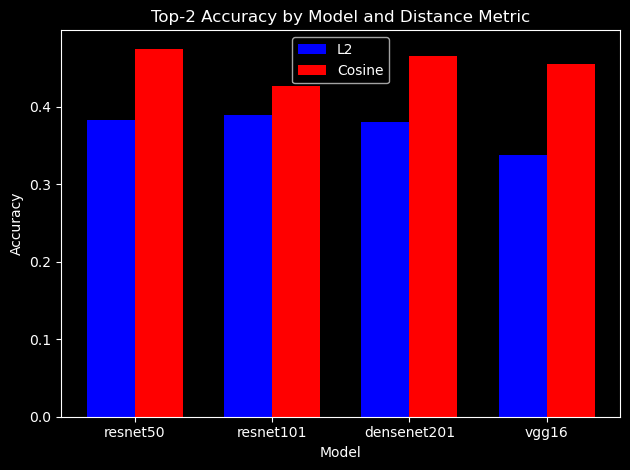

In [ ]:
# Extracting data for plotting
models = list(results.keys())
l2_values = [results[model]['L2'] for model in models]
cosine_values = [results[model]['Cosine'] for model in models]

# Plotting
bar_width = 0.35
index = range(len(models))

fig, ax = plt.subplots()
bar1 = ax.bar(index, l2_values, bar_width, label='L2', color='b')
bar2 = ax.bar([i + bar_width for i in index], cosine_values, bar_width, label='Cosine', color='r')

# Labelling, titling, and formatting
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Top-2 Accuracy by Model and Distance Metric')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

# Store the result to a csv file.

In [ ]:
import csv

def compute_confidences_for_test_model_using_cosine(left_feat_path, right_feat_path, test_left, test_right):
    # Load features
    left_feat = load_data_from_pkl(left_feat_path)
    right_feat = load_data_from_pkl(right_feat_path)

    # Extract features for test set
    test_left_features = [left_feat[filename] for filename in test_left]
    test_right_feat_list = [[right_feat[f] for f in filenames] for filenames in test_right]

    confidences = []

    for i, left_feature in enumerate(test_left_features):
        distances = [distance.cosine(left_feature, right_feature) for right_feature in test_right_feat_list[i]]
        confidences_row = [1 - dist/2 for dist in distances]  # Convert distance to confidence
        confidences.append(confidences_row)

    return confidences

# Compute confidences for ResNet50 on the test set using cosine distance
model = 'resnet50'
left_path = f'feat_test/{model}/{model}_test_left_features.pkl'
right_path = f'feat_test/{model}/{model}_test_right_features.pkl'
confidences = compute_confidences_for_test_model_using_cosine(left_path, right_path, test_left, test_right)

# Save confidences to CSV
# csv_output_path = 'confidences.csv'
# with open(csv_output_path, 'w', newline='') as csvfile:
#     csvwriter = csv.writer(csvfile)
#     # Write header
#     csvwriter.writerow(['left'] + [f'c{i}' for i in range(20)])
#     # Write data rows
#     for i, conf_row in enumerate(confidences):
#         csvwriter.writerow([test_left[i]] + conf_row)

# print(f"Confidences saved to {csv_output_path}")


Confidences saved to confidences.csv


# Train

## Format the data

In [ ]:
def format_and_save_data(train_data, val_data, train_output_path, val_output_path):
    # Format validation data
    formatted_val_data = []
    for left_img, right_images in val_data.items():
        for idx, right_img in enumerate(right_images):
            label = 1 if idx == 0 else 0  # c0 is the ground truth
            formatted_val_data.append((left_img, right_img, label))

    # Format training data
    formatted_train_data = []

    # Add matching pairs to training data
    for left_img, right_img in train_data.items():
        formatted_train_data.append((left_img, right_img, 1))

    # Generate non-matching pairs
    num_negative_samples = len(train_data)
    left_images = list(train_data.keys())
    right_images = list(train_data.values())

    for _ in range(num_negative_samples):
        left_img = random.choice(left_images)
        right_img = random.choice(right_images)
        
        # Ensure it's a non-matching pair
        while train_data[left_img] == right_img:
            left_img = random.choice(left_images)
            right_img = random.choice(right_images)

        formatted_train_data.append((left_img, right_img, 0))
    
    # Save formatted data to pkl files
    with open(train_output_path, 'wb') as f:
        pickle.dump(formatted_train_data, f)
    
    with open(val_output_path, 'wb') as f:
        pickle.dump(formatted_val_data, f)

    print(f"Training data saved to {train_output_path}")
    print(f"Validation data saved to {val_output_path}")

In [ ]:
# format_and_save_data(train_set, val_set, 'train_formated_data.pkl', 'val_formated_data.pkl')

Training data saved to train_formated_data.pkl
Validation data saved to val_formated_data.pkl


In [ ]:
train_data = load_data_from_pkl('train_formated_data.pkl')
val_data = load_data_from_pkl('val_formated_data.pkl')

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

# Define the base model (could be any pre-trained model like ResNet50, VGG16, etc.)
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input, outputs=x)

# Compute Euclidean distance
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

input_shape = (224, 224, 3)

# Define the Siamese Network
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=(1,))([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# Define contrastive loss
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Compile the model
model.compile(optimizer=RMSprop(), loss=contrastive_loss)

# Train the model with your data
# model.fit([train_left_images, train_right_images], labels, epochs=20, batch_size=128)

# For testing, you can use the base_network to extract features for 'left' images and all potential 'right' matches, then compute distances and choose the smallest one.


In [ ]:
train_left_images = [train_data[i][0] for i in range(len(train_data))]

base_path = 'COMP90086_2023_TLLdataset/train/{}/{}.jpg'

for _ in range(len(train_left_images)):
    train_left_images[_] = base_path.format('left', train_left_images[_])
    
train_right_images = [train_data[i][1] for i in range(len(train_data))]

for _ in range(len(train_right_images)):
    train_right_images[_] = base_path.format('right', train_right_images[_])

labels = [train_data[i][2] for i in range(len(train_data))]
labels = np.array(labels)

train_left_images = [imageio.imread(img_path) for img_path in train_left_images]
train_right_images = [imageio.imread(img_path) for img_path in train_right_images]

/var/folders/0z/r_hc_7gs23b9rsb4_jm7750c0000gn/T/ipykernel_6628/384931968.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_left_images = [imageio.imread(img_path) for img_path in train_left_images]
/var/folders/0z/r_hc_7gs23b9rsb4_jm7750c0000gn/T/ipykernel_6628/384931968.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  train_right_images = [imageio.imread(img_path) for img_path in train_right_images]


In [ ]:
val_left_images = [val_data[i][0] for i in range(len(val_data))]

base_path = 'COMP90086_2023_TLLdataset/train/{}/{}.jpg'

for _ in range(len(val_left_images)):
    val_left_images[_] = base_path.format('left', val_left_images[_])
    
val_right_images = [val_data[i][1] for i in range(len(val_data))]

for _ in range(len(val_right_images)):
    val_right_images[_] = base_path.format('right', val_right_images[_])
    
val_labels = [val_data[i][2] for i in range(len(val_data))]
val_labels = np.array(val_labels)
val_labels = val_labels.astype('float32')

val_left_images = [imageio.imread(img_path) for img_path in val_left_images]
val_right_images = [imageio.imread(img_path) for img_path in val_right_images]

# 如果需要，调整图像大小
val_left_images = [cv2.resize(img, (224, 224)) for img in val_left_images]
val_right_images = [cv2.resize(img, (224, 224)) for img in val_right_images]

/var/folders/0z/r_hc_7gs23b9rsb4_jm7750c0000gn/T/ipykernel_6628/3395199880.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  val_left_images = [imageio.imread(img_path) for img_path in val_left_images]
/var/folders/0z/r_hc_7gs23b9rsb4_jm7750c0000gn/T/ipykernel_6628/3395199880.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  val_right_images = [imageio.imread(img_path) for img_path in val_right_images]


In [ ]:
train_left_images = [cv2.resize(img, (224, 224)) for img in train_left_images]
train_right_images = [cv2.resize(img, (224, 224)) for img in train_right_images]

print(np.array(train_left_images).shape)
print(np.array(train_right_images).shape)
print(np.array(labels).shape)

train_left_images = np.array(train_left_images)
train_right_images = np.array(train_right_images)
labels = labels.astype('float32')
labels = np.array(labels)

(3200, 224, 224, 3)
(3200, 224, 224, 3)
(3200,)


In [ ]:

model.fit([train_left_images, train_right_images], labels, epochs=20, batch_size=128)

Epoch 1/20
25/25 [==============================] - 2s 80ms/step - loss: 102624608.0000
Epoch 2/20
25/25 [==============================] - 2s 80ms/step - loss: 29405.5254
Epoch 3/20
25/25 [==============================] - 2s 77ms/step - loss: 4675.7505
Epoch 4/20
25/25 [==============================] - 2s 76ms/step - loss: 933.4783
Epoch 5/20
25/25 [==============================] - 2s 77ms/step - loss: 0.6680
Epoch 6/20
25/25 [==============================] - 2s 77ms/step - loss: 7.3346
Epoch 7/20
25/25 [==============================] - 2s 77ms/step - loss: 0.4997
Epoch 8/20
25/25 [==============================] - 2s 78ms/step - loss: 0.4997
Epoch 9/20
25/25 [==============================] - 2s 77ms/step - loss: 0.4997
Epoch 10/20
25/25 [==============================] - 2s 77ms/step - loss: 0.4997
Epoch 11/20
25/25 [==============================] - 2s 81ms/step - loss: 0.4986
Epoch 12/20
25/25 [==============================] - 2s 79ms/step - loss: 0.4703
Epoch 13/20
25/25 [=

In [ ]:
val_loss = model.evaluate([np.array(val_left_images), np.array(val_right_images)], np.array(val_labels))
print(f"Validation loss: {val_loss}")

250/250 [==============================] - 2s 9ms/step - loss: 17.4575
Validation loss: 17.457481384277344


In [ ]:
def compute_accuracy(predictions, labels, threshold=0.5):
    """
    Compute classification accuracy with a fixed threshold on distances.
    """
    # 根据阈值进行分类预测
    pred_labels = (predictions.ravel() < threshold).astype(int)
    
    return np.mean(pred_labels == labels)

# 使用模型预测验证集上的距离
predictions = model.predict([np.array(val_left_images), np.array(val_right_images)])

# 计算准确率
accuracy = compute_accuracy(predictions, np.array(val_labels))
print(f"Validation accuracy: {accuracy}")


250/250 [==============================] - 2s 9ms/step
Validation accuracy: 0.055375


In [ ]:
train_format_data = load_data_from_pkl('train_formated_data.pkl')
len(train_format_data)

3200

In [ ]:
# get label = 0's pairs

train_label_0 = train_format_data[:5]